In [7]:
import gym
import collections
import numpy as np
import math
import matplotlib.pyplot as plt

# Implementing SARSA

In [3]:
def update_epsilon_sigmoid(t, epsilon_max=1.0, epsilon_min=0.05, slope=0.1, t0=100):
    """
    Sigmoid decay for epsilon.
    
    Parameters:
    - t: current step/episode number.
    - epsilon_max: starting (maximum) epsilon value.
    - epsilon_min: minimum epsilon value.
    - slope: controls the sharpness of the decay.
    - t0: the midpoint where the decay is sharpest.
    
    Returns:
    - epsilon: the updated epsilon value.
    """
    sigmoid = 1 / (1 + math.exp(-slope * (t - t0)))
    epsilon = epsilon_min + (epsilon_max - epsilon_min) * (1 - sigmoid)
    return epsilon

In [141]:
class Agent_SARSA:
    def __init__(self, alpha=0.2, gamma=0.9, epsilon=0.0, printing=False, is_slippery=False):
        """
        Inputs:
        - self: an agent
        - alpha: learning rate
        - gamma: discount factor
        - epsilon: random action probability
        """
        self.env = gym.make(ENV_NAME, render_mode='ansi', is_slippery=is_slippery)
        self.state, _ = self.env.reset()
        self.values = collections.defaultdict(float)
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.printing = printing
    
    def sample_env(self):
        """
        Inputs:
        - self: an agent
        Returns:
        - a tuple: (old_state, action, reward, new_reward)
        """
        old_state = self.state
        action = self.choose_action(old_state)
        new_state, reward, done, _ = self.env.step(action)
        self.state = new_state  # update the current state
        return old_state, action, reward, new_state, done

    def choose_action(self, state):
        """
        Inputs:
        - self: an agent
        - state: current state
        Returns:
        - next_a: the next action taken.
        """
        # Random action P(epsilon)
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample()
        else:
            q_values = [self.values[(state, a)] for a in range(self.env.action_space.n)]

            return int(np.argmax(q_values))

    def value_update(self, s, a, r, next_s, next_a):
        """
        Inputs:
        - self: an agent
        - s: state
        - a: action
        - r: reward
        - next_s: next state
        Returns:
        - self.values[(s, a)]: the updated value of (s, a).
        """
        current_value = self.values[(s, a)]

        next_value = self.values[(next_s, next_a)] if next_a is not None else float(0)
        target = r + self.gamma * next_value
        self.values[(s, a)] = current_value + self.alpha * (target - current_value)
        return self.values[(s, a)]
        
    def play_episode(self, env):
        """
        Inputs:
        - self: an agent
        - env: the environment
        Returns:
        - total_reward: the total reward after playing an
        episode
        """
        if env is None:
            env = self.env

        s, _ = env.reset()
        total_reward = 0
        # Choose initial action using the policy
        a = self.choose_action(s)
        
        done = False
        while not done:
            next_s, r, done, _ , _= env.step(a)
            total_reward += r
            # If we reached terminal state, next action is None
            next_a = self.choose_action(next_s) if not done else None
            if self.printing:
                print('---------')
                print([self.values[(agent.state, a)] for a in range(self.env.action_space.n)])
                print(agent.env.render())
                print('Action Taken: ', next_a)

            # Update the Q-value using the SARSA update rule
            self.value_update(s, a, r, next_s, next_a)
            
            # Move to the next state and action
            s, a = next_s, next_a
        
        return total_reward

In [183]:
def genplots(rewards, epsilon_max, epsilon_min, slope, t0, episodes):
    moving_avg = np.convolve(rewards, np.ones(window_size)/window_size, mode='valid')
    avg_episodes = np.arange(window_size, len(rewards) + 1)
    
    steps = np.arange(1, episodes+1)
    epsilons = [update_epsilon_sigmoid(t, slope=slope, t0=t0, epsilon_max=epsilon_max, epsilon_min=epsilon_min) for t in steps]
    
    # Create a combined plot with two y-axes
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    # Plot epsilon on the left y-axis
    color = 'blue'
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Epsilon', color=color)
    ax1.set_ylim([0, 1])
    ax1.plot(steps, epsilons, color=color, label='Epsilon (Sigmoid Decay)')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.grid(True)
    
    # Create a second y-axis for the moving average of rewards
    ax2 = ax1.twinx()
    color = 'green'
    ax2.set_ylabel('Moving Average of Rewards', color=color)
    ax2.plot(avg_episodes, moving_avg, color=color, label='Moving Average (100 rewards)')
    ax2.tick_params(axis='y', labelcolor=color)
    
    # Add a title and display the plot
    fig.tight_layout()
    plt.title("Epsilon Decay and Moving Average of Rewards Over Episodes")
    plt.show()

In [184]:
def simulate(ENV_NAME, GAMMA, ALPHA, TEST_EPISODES, epsilon_max, epsilon_min, epsilon_slope, epsilon_t0, printing, is_slippery):

    agent = Agent_SARSA(alpha=ALPHA, gamma=GAMMA, epsilon=0.01, printing=printing, is_slippery=is_slippery)
    rewards = []
    
    for ep in range(TEST_EPISODES):
        total_r = agent.play_episode(agent.env)
        agent.epsilon = update_epsilon_sigmoid(ep, epsilon_max=epsilon_max, epsilon_min=epsilon_min, slope=0.1, t0=500) 
        rewards.append(total_r)
        if printing:
            if (ep + 1) % 100 == 0:
                print(f"Episode {ep+1}, Total Reward: {sum(rewards)}, Rewards Per Episode of this 100: {sum(rewards[-100:])/100}")
    
    genplots(rewards, slope=epsilon_slope, t0=epsilon_t0, epsilon_max=epsilon_max, epsilon_min=epsilon_min, episodes=TEST_EPISODES)

# Experiments with SARSA

In [185]:
ENV_NAME='FrozenLake-v1'
GAMMA=0.9
ALPHA=0.2
TEST_EPISODES=10000
epsilon_max = 0
epsilon_min = 0
epsilon_slope=0.01
epsilon_t0 = 500
printing=False
is_slippery=False

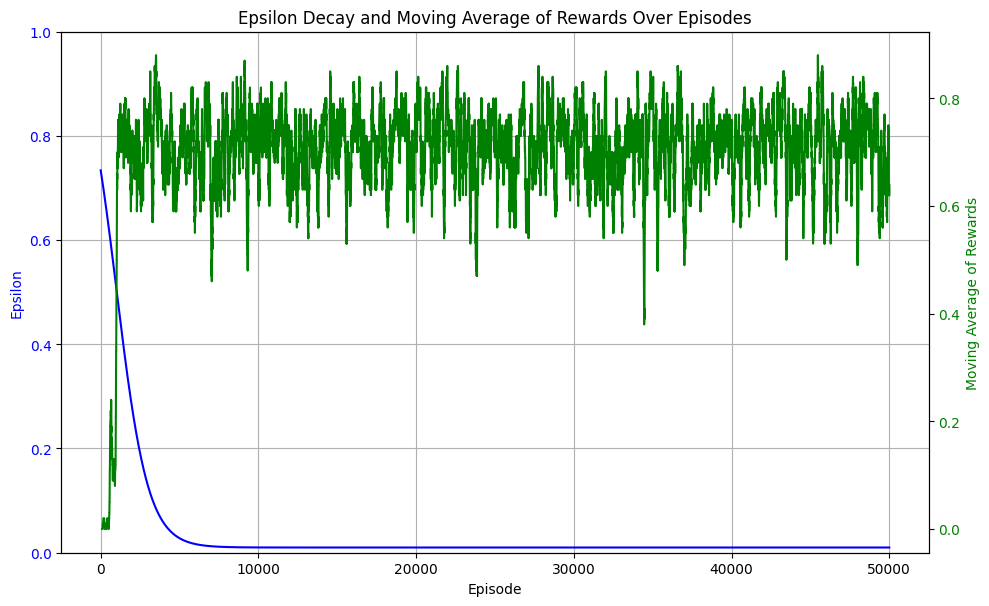

In [189]:
simulate(ENV_NAME=ENV_NAME, GAMMA=0.9999, ALPHA=0.25, TEST_EPISODES=50000, 
         epsilon_max=1.0, epsilon_min=0.01, 
         epsilon_slope=0.001, epsilon_t0=1000, 
         printing=printing, is_slippery=True)

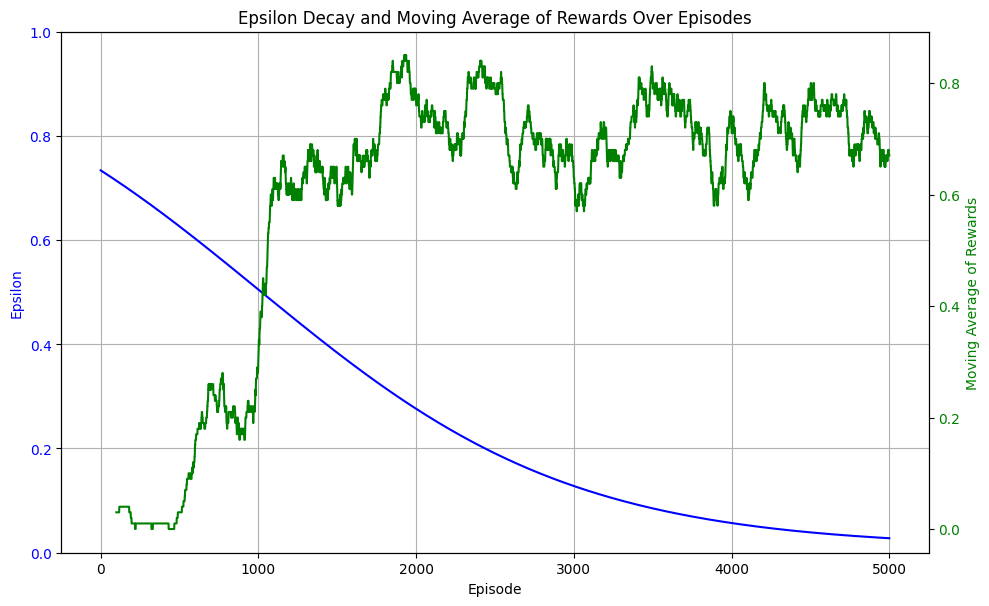

In [190]:
simulate(ENV_NAME=ENV_NAME, GAMMA=0.9999, ALPHA=0.25, TEST_EPISODES=5000, 
         epsilon_max=1.0, epsilon_min=0.01, 
         epsilon_slope=0.001, epsilon_t0=1000, 
         printing=printing, is_slippery=True)

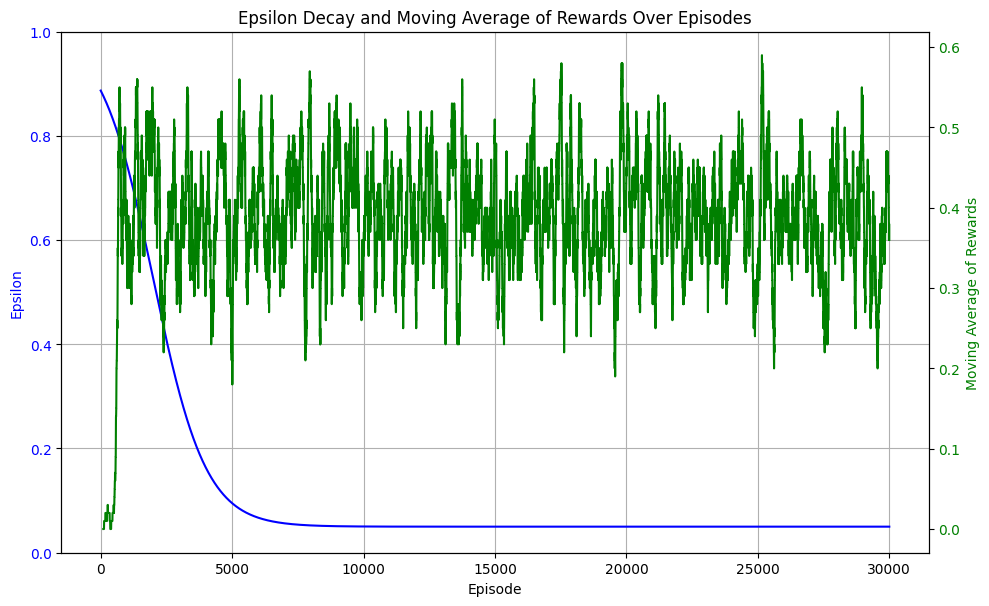

In [200]:
simulate(ENV_NAME=ENV_NAME, GAMMA=0.9999, ALPHA=0.40, TEST_EPISODES=30000, 
         epsilon_max=1.0, epsilon_min=0.05, 
         epsilon_slope=0.001, epsilon_t0=2000, 
         printing=printing, is_slippery=True)

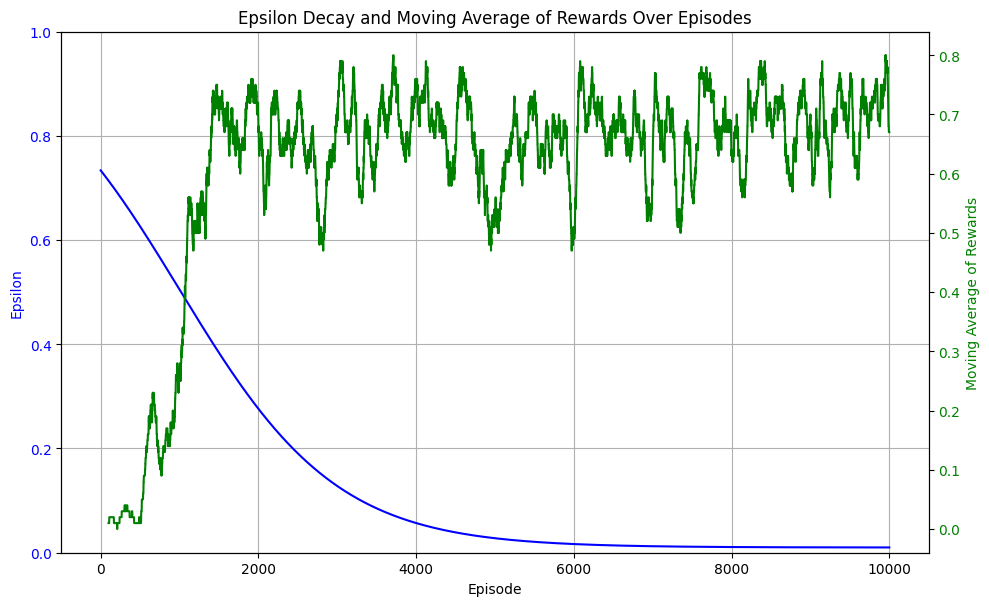

In [201]:
simulate(ENV_NAME=ENV_NAME, GAMMA=0.9999, ALPHA=0.25, TEST_EPISODES=10000, 
         epsilon_max=1.0, epsilon_min=0.01, 
         epsilon_slope=0.001, epsilon_t0=1000, 
         printing=printing, is_slippery=True)

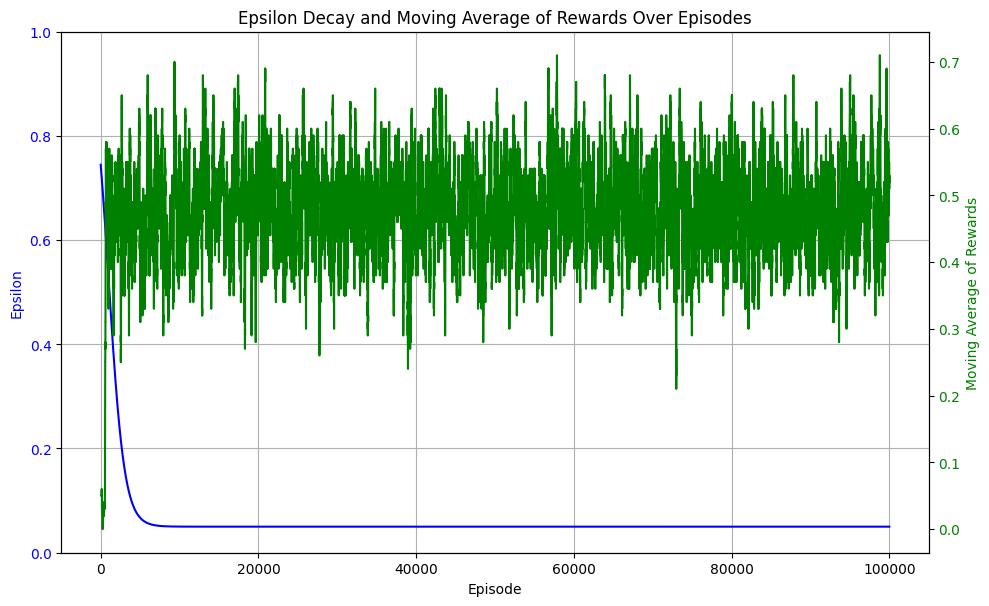

In [203]:
simulate(ENV_NAME=ENV_NAME, GAMMA=0.9999, ALPHA=0.25, TEST_EPISODES=100000, 
         epsilon_max=1.0, epsilon_min=0.05, 
         epsilon_slope=0.001, epsilon_t0=1000, 
         printing=printing, is_slippery=True)

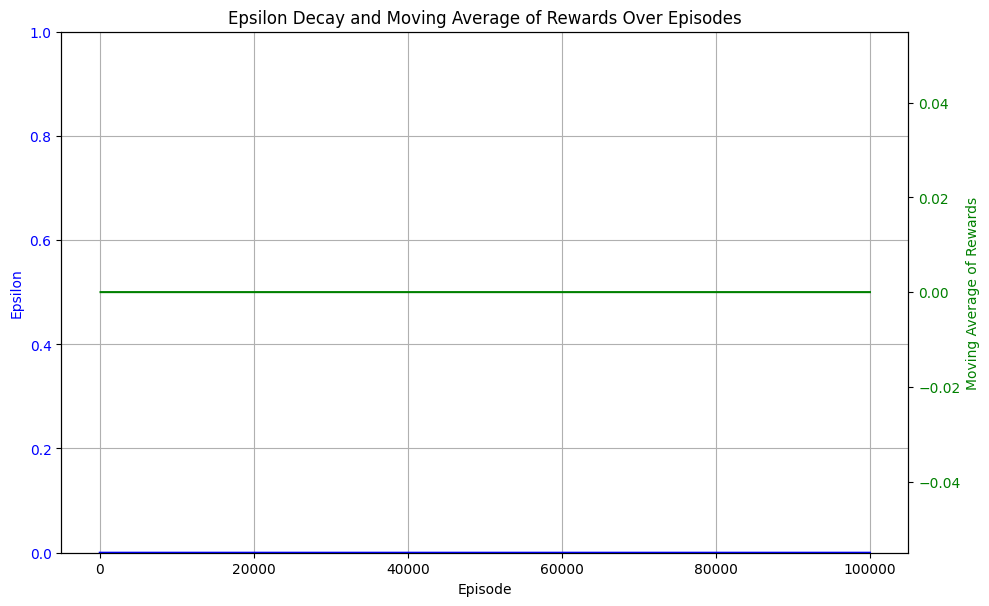

In [205]:
simulate(ENV_NAME=ENV_NAME, GAMMA=0.9999, ALPHA=0.25, TEST_EPISODES=100000, 
         epsilon_max=0.0, epsilon_min=0.0, 
         epsilon_slope=0.001, epsilon_t0=1000, 
         printing=printing, is_slippery=True)

# Implementing Q-Learning

In [213]:
class Agent_QLearning:
    def __init__(self, alpha=0.2, gamma=0.9, epsilon=0.0, printing=False, is_slippery=False):
        """
        Inputs:
        - alpha: learning rate
        - gamma: discount factor
        - epsilon: probability for taking a random action (exploration)
        - printing: if True, print debugging info
        - is_slippery: whether the FrozenLake is slippery or not
        """
        self.env = gym.make(ENV_NAME, render_mode='ansi', is_slippery=is_slippery)
        self.state, _ = self.env.reset()
        self.values = collections.defaultdict(float)
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.printing = printing

    def sample_env(self):
        """
        Inputs:
        - self: an agent
        Returns:
        - a tuple: (old_state, action, reward, new_state, done)
        """
        old_state = self.state
        action = self.choose_action(old_state)
        new_state, reward, done, _ = self.env.step(action)
        self.state = new_state  # update the current state
        return old_state, action, reward, new_state, done

    def choose_action(self, state):
        """
        Inputs:
        - state: current state
        
        Returns:
        - chosen action
        """
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample()
        else:
            q_values = [self.values[(state, a)] for a in range(self.env.action_space.n)]
            return int(np.argmax(q_values))

    def best_value_and_action(self, state):
        """
        Inputs:
        - state: current state
        
        Returns:
        - best_value: highest Q-value among actions at state
        - best_action: action corresponding to best_value
        """
        q_values = [self.values[(state, a)] for a in range(self.env.action_space.n)]
        best_value = max(q_values)
        best_action = int(np.argmax(q_values))
        return best_value, best_action

    def value_update(self, s, a, r, next_s):
        """
        Inputs:
        - s: current state
        - a: action taken in state s
        - r: reward received after taking action a
        - next_s: next state
          
        Returns:
        - Updated Q-value for (s, a)
        """
        current_value = self.values[(s, a)]
        # For Q-learning, we use the maximum Q-value for the next state
        next_q_values = [self.values[(next_s, a_prime)] for a_prime in range(self.env.action_space.n)]
        max_next_value = max(next_q_values) if next_q_values else 0.0
        target = r + self.gamma * max_next_value
        self.values[(s, a)] = current_value + self.alpha * (target - current_value)
        return self.values[(s, a)]
        
    def play_episode(self, env=None):
        """
        Inputs:
        - env: the environment to use (if None, self.env is used)
        
        Returns:
        - total_reward: total reward accumulated in the episode
        """
        if env is None:
            env = self.env

        s, _ = env.reset()
        total_reward = 0
        done = False
        
        while not done:
            action = self.choose_action(s)
            next_s, r, done, _, _ = env.step(action)
            total_reward += r
            
            if self.printing:
                print("State:", s, "Action:", action, "Reward:", r)
                print("Next state:", next_s)
                print("Q-values:", [self.values[(s, a)] for a in range(self.env.action_space.n)])
                print("-----")
            
            # Q-learning update (note: no next action is needed here)
            self.value_update(s, action, r, next_s)
            
            # Move to next state
            s = next_s
        
        return total_reward

In [214]:
def simulateQ(ENV_NAME, GAMMA, ALPHA, TEST_EPISODES, epsilon_max, epsilon_min, epsilon_slope, epsilon_t0, printing, is_slippery):

    agent = Agent_QLearning(alpha=ALPHA, gamma=GAMMA, epsilon=0.01, printing=printing, is_slippery=is_slippery)
    rewards = []
    
    for ep in range(TEST_EPISODES):
        total_r = agent.play_episode(agent.env)
        agent.epsilon = update_epsilon_sigmoid(ep, epsilon_max=epsilon_max, epsilon_min=epsilon_min, slope=0.1, t0=500) 
        rewards.append(total_r)
        if printing:
            if (ep + 1) % 100 == 0:
                print(f"Episode {ep+1}, Total Reward: {sum(rewards)}, Rewards Per Episode of this 100: {sum(rewards[-100:])/100}")
    
    genplots(rewards, slope=epsilon_slope, t0=epsilon_t0, epsilon_max=epsilon_max, epsilon_min=epsilon_min, episodes=TEST_EPISODES)

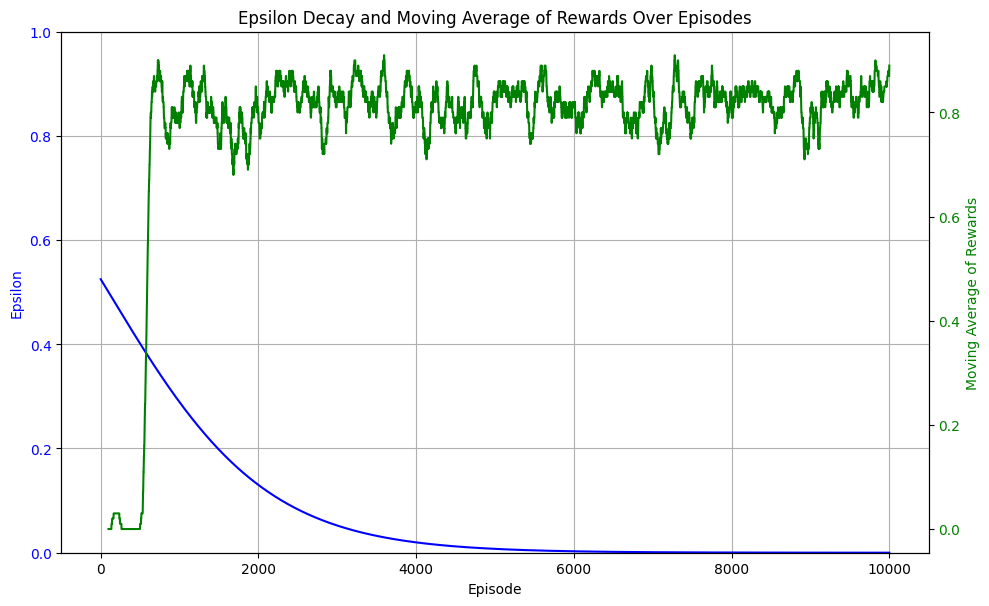

In [217]:
simulateQ(ENV_NAME=ENV_NAME, GAMMA=0.9999, ALPHA=0.25, TEST_EPISODES=10000, 
         epsilon_max=1.0, epsilon_min=0.0, 
         epsilon_slope=0.001, epsilon_t0=100, 
         printing=printing, is_slippery=True)

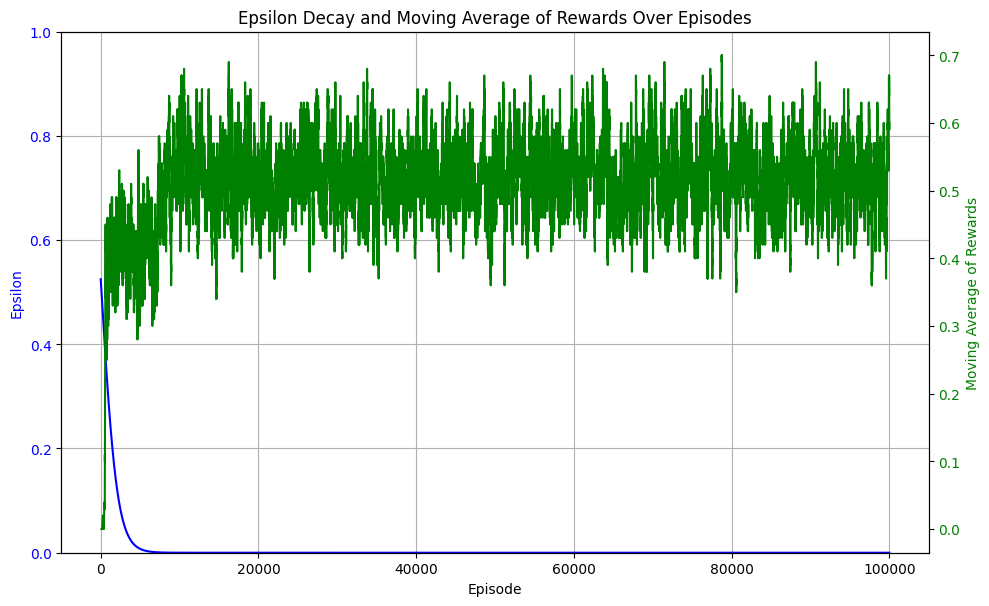

In [221]:
simulateQ(ENV_NAME=ENV_NAME, GAMMA=0.99, ALPHA=0.20, TEST_EPISODES=100000, 
         epsilon_max=1.0, epsilon_min=0.0, 
         epsilon_slope=0.001, epsilon_t0=100, 
         printing=printing, is_slippery=True)

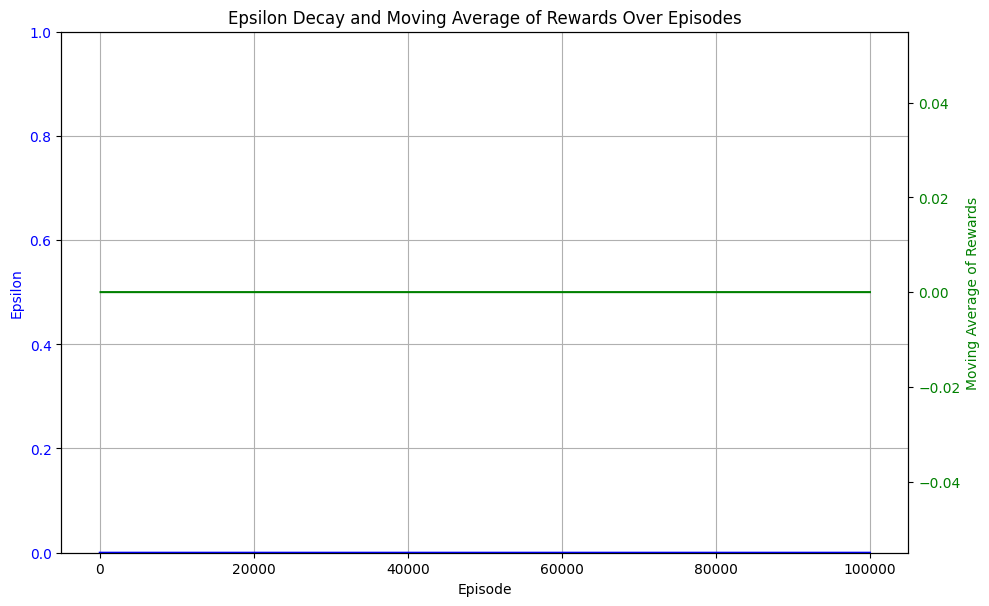

In [222]:
simulateQ(ENV_NAME=ENV_NAME, GAMMA=0.99, ALPHA=0.20, TEST_EPISODES=100000, 
         epsilon_max=0.0, epsilon_min=0.0, 
         epsilon_slope=0.001, epsilon_t0=100, 
         printing=printing, is_slippery=True)